<a href="https://colab.research.google.com/github/dijashahzad746/deep-learning/blob/main/CNN(skin_lesion_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from imblearn.combine import SMOTEENN
import time

In [2]:
from google.colab import files
uploaded=files.upload()

Saving hmnist_28_28_RGB.csv to hmnist_28_28_RGB.csv


In [3]:
data = pd.read_csv('/content/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [4]:
X = data.iloc[:,:2352]
y = data.iloc[:,-1]

In [5]:
y.value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

In [6]:
unique_classes, class_counts = np.unique(y, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} sampel")

Class 0: 327 sampel
Class 1: 514 sampel
Class 2: 1099 sampel
Class 3: 115 sampel
Class 4: 6705 sampel
Class 5: 142 sampel
Class 6: 1113 sampel


In [7]:
class_labels=["akiec","bcc","bkl","df","mel","nv","vasc"]

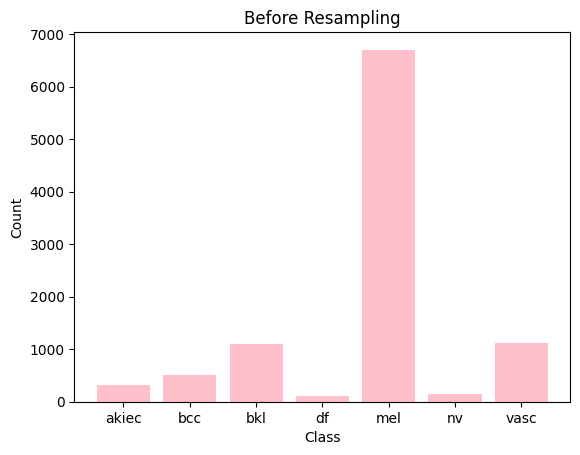

In [8]:
# Plot the bar graph
class_counts = y.value_counts().sort_index()
plt.bar(class_labels, class_counts.values, color='pink')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Before Resampling')

# Show the plot
plt.show()

In [10]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled_df = smote_enn.fit_resample(X, y)


unique_classes, class_counts = np.unique(y_resampled_df, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Kelas {cls}: {count} sampel")

Kelas 0: 6705 sampel
Kelas 1: 6702 sampel
Kelas 2: 6597 sampel
Kelas 3: 6705 sampel
Kelas 4: 3464 sampel
Kelas 5: 6705 sampel
Kelas 6: 6595 sampel


In [11]:
X_resampled = np.array(X_resampled).reshape(-1, 28, 28, 3)
print('Shape of Data :', X_resampled.shape)

Shape of Data : (43473, 28, 28, 3)


In [12]:
from tensorflow.keras.utils import to_categorical

y_resampled = np.array(y_resampled_df)
y_resampled = to_categorical(y_resampled)
print('Shape of Data :', y_resampled.shape)

Shape of Data : (43473, 7)


In [13]:
X_train , X_test , y_train , y_test = train_test_split(X_resampled , y_resampled , test_size = 0.25 , random_state = 42)

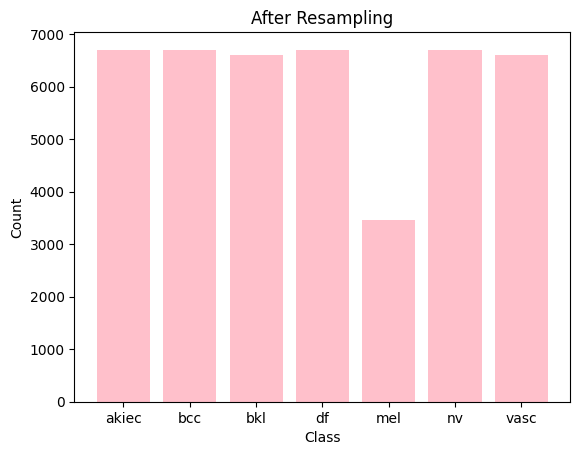

In [14]:
# Plot the bar graph
class_counts = y_resampled_df.value_counts().sort_index()
plt.bar(class_labels, class_counts.values, color='pink')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('After Resampling')

# Show the plot
plt.show()

In [15]:
model = tf.keras.Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),

    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    BatchNormalization(),

    Dense(7, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                        

In [16]:
# Callback to save the best model
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Minimization mode for validation loss
    verbose=1  # Display messages when saving the model
)

# Callback to reduce learning rate when validation loss stagnates
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,  # Learning rate reduction factor (0.2 = 20%)
    patience=3,
    min_lr=0.0001,  # Lower bound for learning rate
    verbose=1  # Display messages when reducing learning rate
)

# Callback to stop training if validation loss doesn't improve for several epochs
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs without improvement before stopping training
    verbose=1,  # Display messages when stopping training
    restore_best_weights=True  # Restore the best weights when stopping training
)

In [17]:
start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=25,
    validation_data=(X_test, y_test),
    callbacks=[model_checkpoint_callback, reduce_lr_callback, early_stopping_callback]
)

end_time = time.time()
training_time = (end_time - start_time)/60
print(f"Total training time: {training_time} minutes")

Epoch 1/25
1019/1019 [==============================] - ETA: 0s - loss: 0.8243 - accuracy: 0.7012
Epoch 1: val_loss improved from inf to 1.80890, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1019/1019 [==============================] - 210s 202ms/step - loss: 0.8243 - accuracy: 0.7012 - val_loss: 1.8089 - val_accuracy: 0.4304 - lr: 0.0010
Epoch 2/25
1019/1019 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.8373
Epoch 2: val_loss improved from 1.80890 to 0.64682, saving model to best_model.h5
1019/1019 [==============================] - 203s 199ms/step - loss: 0.4579 - accuracy: 0.8373 - val_loss: 0.6468 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 3/25
1019/1019 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.8861
Epoch 3: val_loss did not improve from 0.64682
1019/1019 [==============================] - 211s 207ms/step - loss: 0.3275 - accuracy: 0.8861 - val_loss: 2.1278 - val_accuracy: 0.6271 - lr: 0.0010
Epoch 4/25
1019/1019 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9165
Epoch 4: val_loss improved from 0.64682 to 0.48040, saving model to best_model.h5
1019/1019 [==============================] - 

In [18]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

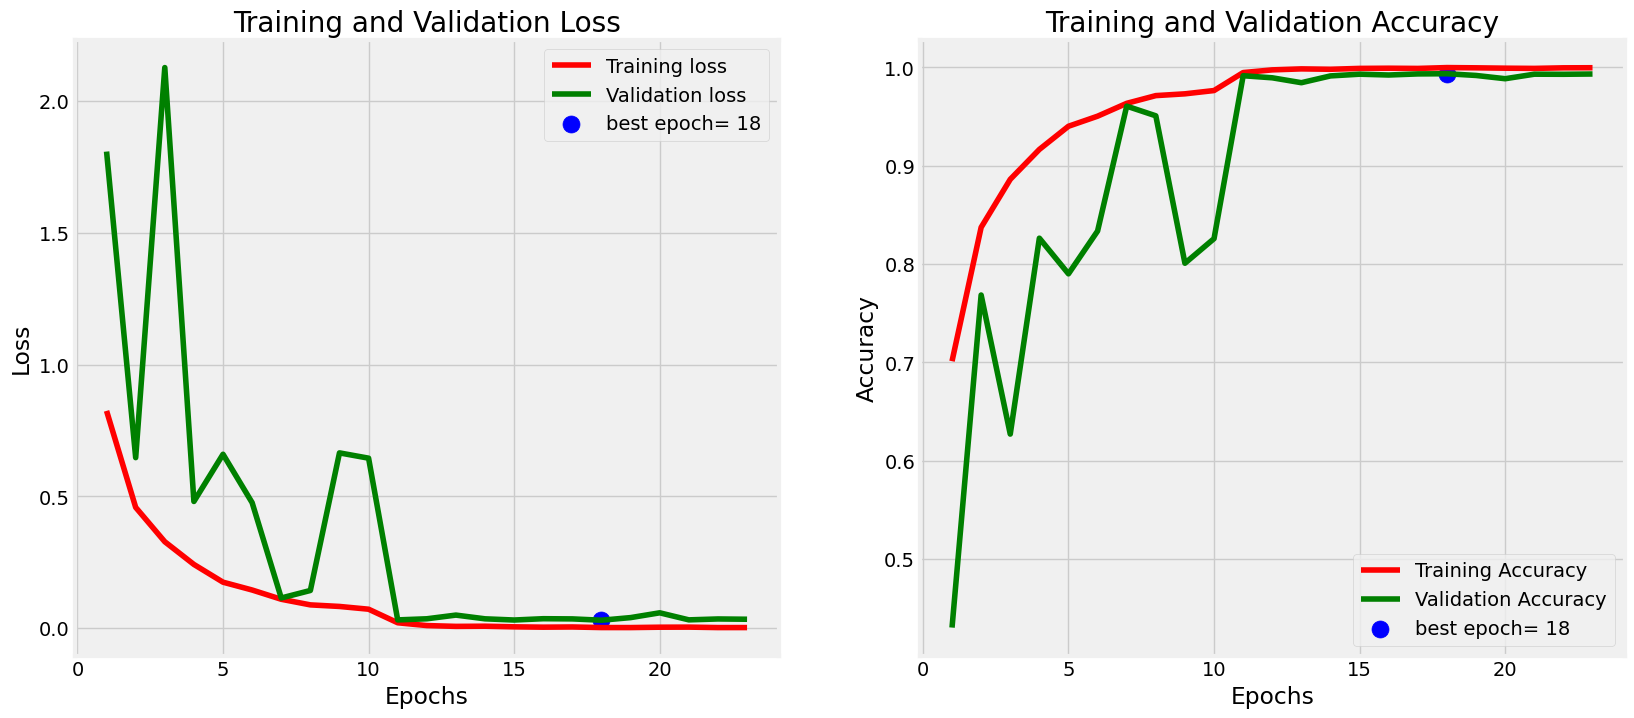

In [19]:
plot_training(history)

In [20]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

340/340 [==============================] - 15s 45ms/step - loss: 0.0295 - accuracy: 0.9935
Train Loss:  0.0004301864537410438
Train Accuracy:  0.9999386668205261
--------------------
Test Loss:  0.029451631009578705
Test Accuracy:  0.9934676885604858


In [21]:
y_pred = model.predict(X_test)

340/340 [==============================] - 18s 52ms/step


In [22]:
y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_test , axis=1)

In [23]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

In [24]:
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9934676603183366
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1754
           1       1.00      1.00      1.00      1686
           2       0.99      0.99      0.99      1629
           3       1.00      1.00      1.00      1612
           4       0.99      0.96      0.98       864
           5       1.00      1.00      1.00      1625
           6       0.98      0.99      0.99      1699

    accuracy                           0.99     10869
   macro avg       0.99      0.99      0.99     10869
weighted avg       0.99      0.99      0.99     10869



In [25]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

In [26]:
from sklearn.metrics import confusion_matrix
import itertools

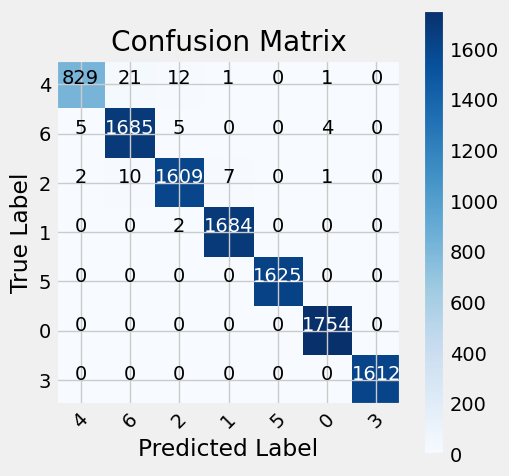

In [27]:
# Confusion matrix
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [29]:
# y_test_unique_classes, y_test_class_counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
num = 0
for cls, count in zip(classes_labels, [864, 1699, 1629, 1686, 1625, 1754, 1612]):
    print(f"Class {cls}: {cm[num,num]} from {count} sampel, incorrect prediction: {count-cm[num,num]}")
    num += 1

Class 4: 829 from 864 sampel, incorrect prediction: 35
Class 6: 1685 from 1699 sampel, incorrect prediction: 14
Class 2: 1609 from 1629 sampel, incorrect prediction: 20
Class 1: 1684 from 1686 sampel, incorrect prediction: 2
Class 5: 1625 from 1625 sampel, incorrect prediction: 0
Class 0: 1754 from 1754 sampel, incorrect prediction: 0
Class 3: 1612 from 1612 sampel, incorrect prediction: 0
